### Load data

In [1]:
import findspark
findspark.init('/Users/xuejiwang/spark/spark-2.3.2-bin-hadoop2.7')

In [2]:
from pyspark.sql import SparkSession

In [3]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [4]:
spark = SparkSession.builder.appName("basics").getOrCreate()

In [6]:
df = spark.read.csv('/Users/xuejiwang/Documents/dev/MusicBox/data/df_final.csv',header=True,inferSchema=True).cache()
df.show(5)

+---------+-----+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+-------------+-------------+-------------+--------------+--------------+---------+---------+---------+-------------------+-------------------+-------------------+--------------------+--------------------+----------------------+----------------------+----------------------+-----------------------+-----------------------+-----------+
|      uid|label|freq_P_last_1|freq_P_last_3|freq_P_last_7|freq_P_last_14|freq_P_last_30|freq_D_last_1|freq_D_last_3|freq_D_last_7|freq_D_last_14|freq_D_last_30|freq_S_last_1|freq_S_last_3|freq_S_last_7|freq_S_last_14|freq_S_last_30|recency_P|recency_D|recency_S|tot_playtime_last_1|tot_playtime_last_3|tot_playtime_last_7|tot_playtime_last_14|tot_playtime_last_30|count_80per_song_last1|count_80per_song_last3|count_80per_song_last7|count_80per_song_last14|count_80per_song_last30|device_type|
+---------

### Prepare training data

In [7]:
selected_features = df.columns
selected_features.remove('uid')
selected_features.remove('label')
selected_features.remove('device_type')
selected_features

['freq_P_last_1',
 'freq_P_last_3',
 'freq_P_last_7',
 'freq_P_last_14',
 'freq_P_last_30',
 'freq_D_last_1',
 'freq_D_last_3',
 'freq_D_last_7',
 'freq_D_last_14',
 'freq_D_last_30',
 'freq_S_last_1',
 'freq_S_last_3',
 'freq_S_last_7',
 'freq_S_last_14',
 'freq_S_last_30',
 'recency_P',
 'recency_D',
 'recency_S',
 'tot_playtime_last_1',
 'tot_playtime_last_3',
 'tot_playtime_last_7',
 'tot_playtime_last_14',
 'tot_playtime_last_30',
 'count_80per_song_last1',
 'count_80per_song_last3',
 'count_80per_song_last7',
 'count_80per_song_last14',
 'count_80per_song_last30']

In [8]:
# training data
assembler = VectorAssembler(
    inputCols=selected_features,
    outputCol="features")
data = assembler.transform(df.fillna(0))

# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

### Fit logistic regression

In [9]:
ml = LogisticRegression(maxIter=3, regParam=0.01)
model = ml.fit(train)

In [10]:
# Print the coefficients and intercepts for logistic regression with multinomial family
print("Multinomial coefficients: " + str(model.coefficientMatrix))
print("Multinomial intercepts: " + str(model.interceptVector))

Multinomial coefficients: DenseMatrix([[-0.00855519, -0.004537  , -0.00274707, -0.0014715 , -0.00048801,
              -0.01187783, -0.00712753, -0.00474238, -0.00237547, -0.00135046,
              -0.07215539, -0.05671387, -0.02640045, -0.01379137, -0.00541299,
               0.06746044, -0.01087851,  0.00120499, -0.00852337, -0.00452288,
              -0.00274112, -0.00147263, -0.00048707, -0.01751774, -0.00851355,
              -0.00461712, -0.0021716 , -0.00065906]])
Multinomial intercepts: [0.4884716436995974]


### Predict and Evaluate performance

In [11]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()


+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.19397466328242...|       1.0|    1|(28,[4,14,15,17,2...|
|[0.99396151947135...|       0.0|    0|[4.0,57.0,168.0,3...|
|[0.15962623874530...|       1.0|    1|(28,[4,15,22],[11...|
|[0.35492008974484...|       1.0|    1|(28,[3,4,15,21,22...|
|[0.44130510189910...|       1.0|    0|(28,[0,1,2,3,4,18...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.92525228991764...|       0.0|    0|(28,[0,1,2,3,4,14...|
|[0.21329043205662...|       1.0|    0|(28,[3,4,15,21,22...|
|[0.66023558051249...|       0.0|    0|(28,[1,2,3,4,13,1...|
|[0.54893617888928...|       0.0|    1|(28,[4,6,7,8,9,14...|

### Evaluate performance

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score

def plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    

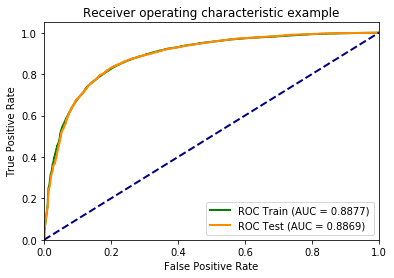

In [13]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Let's train random forest

In [14]:
ml = RandomForestClassifier(labelCol="label", featuresCol="features"
                            ,numTrees=50#50
                            ,featureSubsetStrategy="auto"
                            ,impurity='gini'
                            ,maxDepth=12#20
                            ,minInstancesPerNode=10
                            ,maxBins=16
                            )
model = ml.fit(train)

In [15]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.23264323946666...|       1.0|    1|(28,[4,14,15,17,2...|
|[0.99734995407519...|       0.0|    0|[4.0,57.0,168.0,3...|
|[0.12804804986534...|       1.0|    1|(28,[4,15,22],[11...|
|[0.11402303595470...|       1.0|    1|(28,[3,4,15,21,22...|
|[0.57839295812066...|       0.0|    0|(28,[0,1,2,3,4,18...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.96329113571274...|       0.0|    0|(28,[0,1,2,3,4,14...|
|[0.37493313780528...|       1.0|    0|(28,[3,4,15,21,22...|
|[0.91573592044884...|       0.0|    0|(28,[1,2,3,4,13,1...|
|[0.32207970929008...|       1.0|    1|(28,[4,6,7,8,9,14...|

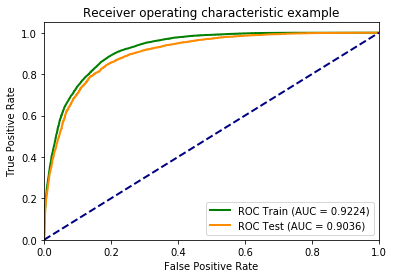

In [16]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)

### Gradient-boosted tree classifier

In [17]:
from pyspark.ml.classification import GBTClassifier

In [18]:
ml = GBTClassifier(labelCol="label", featuresCol="features",maxIter=10)
model = ml.fit(train)

In [19]:
#### predict and evaluate performance

# Predict train data
predictions_train = model.transform(train)

# Select example rows to display.
predictions_train.select("probability","prediction", "label", "features").show(5)
res_train = predictions_train.select("probability", "label").toPandas()


# Predict test data
predictions_test = model.transform(test)

# Select example rows to display.
predictions_test.select("probability","prediction", "label", "features").show(5)
res_test = predictions_test.select("probability", "label").toPandas()

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.37399523784436...|       1.0|    1|(28,[4,14,15,17,2...|
|[0.92660403598862...|       0.0|    0|[4.0,57.0,168.0,3...|
|[0.18542157370563...|       1.0|    1|(28,[4,15,22],[11...|
|[0.08575213671681...|       1.0|    1|(28,[3,4,15,21,22...|
|[0.48383954041877...|       1.0|    0|(28,[0,1,2,3,4,18...|
+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+----------+-----+--------------------+
|         probability|prediction|label|            features|
+--------------------+----------+-----+--------------------+
|[0.91642105709169...|       0.0|    0|(28,[0,1,2,3,4,14...|
|[0.30981343080365...|       1.0|    0|(28,[3,4,15,21,22...|
|[0.87093485908096...|       0.0|    0|(28,[1,2,3,4,13,1...|
|[0.25672099778301...|       1.0|    1|(28,[4,6,7,8,9,14...|

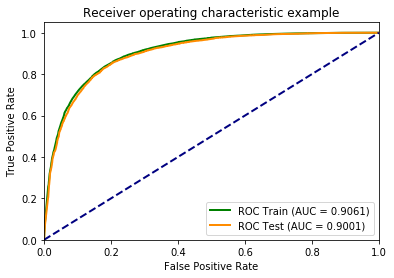

In [20]:
y_train = res_train['label']
y_train_pred = [v[1] for v in res_train['probability']]
y_test = res_test['label']
y_test_pred = [v[1] for v in res_test['probability']]

plot_roc_curve(y_train, y_train_pred, y_test, y_test_pred)